In [1]:
from qiskit import QuantumCircuit, transpile
from qiskit_ibm_runtime import QiskitRuntimeService 

from qiskit_aer import AerSimulator
from qiskit_aer.noise import NoiseModel

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
N_SHOTS = 1024
# N_SHOTS = 4000
SEED_TRANSPILER = 11032024
SEED_SIMULATOR = 10590589

service = QiskitRuntimeService()
backend = service.backend("ibm_brisbane")
backend.configuration().basis_gates

['ecr', 'id', 'rz', 'sx', 'x']

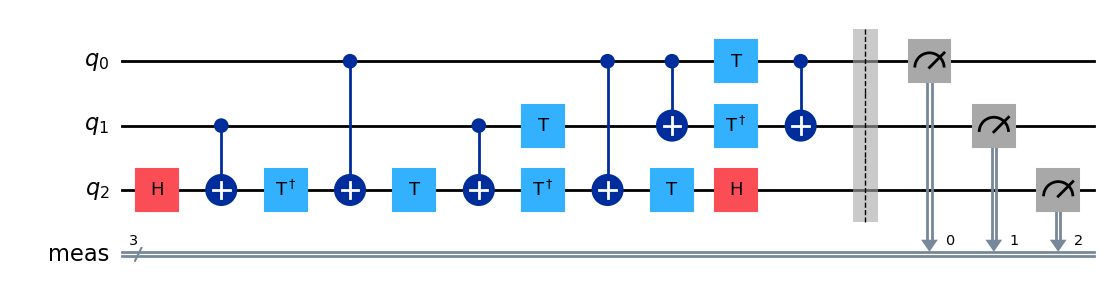

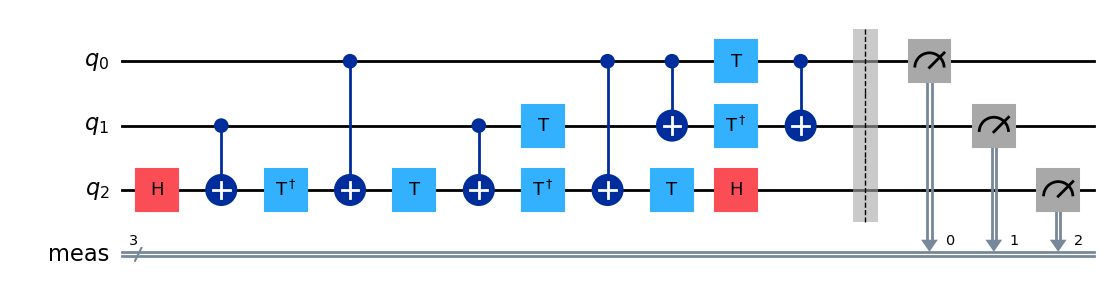

In [3]:
qc = QuantumCircuit(3)
qc.h(2)
qc.cx(1, 2)
qc.tdg(2)
qc.cx(0, 2)
qc.t(2)
qc.cx(1, 2)
qc.tdg(2)
qc.cx(0, 2)
qc.t(1)
qc.t(2)
qc.cx(0, 1)
qc.h(2)
qc.t(0)
qc.tdg(1)
qc.cx(0, 1)
qc.measure_all()

qc.draw(output='mpl')

In [4]:
filter_f = lambda x: x.operation.name not in ['barrier', 'measure']
qc.depth(filter_f)

11

In [5]:
isa_qc = transpile(qc, backend, seed_transpiler=SEED_TRANSPILER)
isa_qc.depth(filter_f)

32

In [6]:
from itertools import product

qc_all = {}
for s in product('01', repeat=3):
    bit_s = ''.join(s)
    new_qc = QuantumCircuit(3)
    for i, c in enumerate(reversed(bit_s)): 
        if c == '1':
            new_qc.x(i)
    new_qc.compose(qc, inplace=True)
    new_qc = transpile(new_qc, backend, seed_transpiler=SEED_TRANSPILER)
    qc_all[bit_s] = new_qc

In [7]:
sim_ideal = AerSimulator(shots=N_SHOTS)

counts_ideal = {}
job_ideal = sim_ideal.run(list(qc_all.values()))
res_ideal = job_ideal.result()
for k, v in zip(qc_all.keys(), res_ideal.get_counts()):
    counts_ideal[k] = v
counts_ideal

{'000': {'000': 1024},
 '001': {'001': 1024},
 '010': {'010': 1024},
 '011': {'111': 1024},
 '100': {'100': 1024},
 '101': {'101': 1024},
 '110': {'110': 1024},
 '111': {'011': 1024}}

In [8]:
noise_model = NoiseModel.from_backend(backend)
sim_noisy = AerSimulator(noise_model=noise_model, seed_simulator=SEED_SIMULATOR, shots=N_SHOTS) 

counts_sim_noisy = {}
job_sim_noisy = sim_noisy.run(list(qc_all.values()))
res_sim_noisy = job_sim_noisy.result()
for k, v in zip(qc_all.keys(), res_sim_noisy.get_counts()):
    counts_sim_noisy[k] = v
counts_sim_noisy

{'000': {'101': 2, '100': 22, '001': 14, '011': 4, '010': 17, '000': 965},
 '001': {'010': 1,
  '000': 10,
  '011': 22,
  '111': 4,
  '001': 964,
  '100': 4,
  '101': 19},
 '010': {'011': 8, '111': 5, '110': 24, '100': 1, '000': 15, '010': 971},
 '011': {'010': 2, '101': 13, '111': 985, '011': 16, '100': 2, '110': 6},
 '100': {'111': 1,
  '000': 23,
  '010': 3,
  '101': 14,
  '001': 1,
  '110': 27,
  '100': 955},
 '101': {'110': 4,
  '100': 15,
  '001': 15,
  '011': 4,
  '111': 15,
  '000': 4,
  '101': 967},
 '110': {'101': 1, '110': 977, '100': 12, '111': 9, '011': 4, '010': 21},
 '111': {'111': 19, '001': 17, '101': 3, '010': 5, '011': 980}}

In [12]:
from qiskit_ibm_runtime import SamplerV2 as Sampler

sampler_true = Sampler(mode=backend)
job = sampler_true.run(list(qc_all.values()), shots=N_SHOTS)

# Use the job ID to retrieve your job data later
print(f">>> Job ID: {job.job_id()}")

res_true = job.result()

>>> Job ID: czd9qnyb7tt0008gngn0


In [16]:
counts_true = {}
for k, v in zip(qc_all.keys(), res_true):
    counts_true[k] = v.data.meas.get_counts()
counts_true

{'000': {'000': 869,
  '100': 50,
  '011': 11,
  '010': 57,
  '001': 22,
  '101': 11,
  '110': 4},
 '001': {'001': 904,
  '111': 13,
  '011': 20,
  '000': 23,
  '101': 61,
  '100': 2,
  '010': 1},
 '010': {'010': 901, '111': 12, '110': 76, '000': 18, '011': 15, '001': 2},
 '011': {'111': 911,
  '011': 48,
  '010': 13,
  '001': 13,
  '101': 15,
  '110': 20,
  '100': 4},
 '100': {'100': 882, '000': 67, '101': 20, '001': 11, '110': 34, '111': 10},
 '101': {'101': 902,
  '010': 2,
  '100': 24,
  '001': 59,
  '111': 15,
  '011': 15,
  '110': 5,
  '000': 2},
 '110': {'110': 915,
  '100': 16,
  '010': 66,
  '011': 13,
  '111': 11,
  '001': 1,
  '000': 1,
  '101': 1},
 '111': {'011': 907,
  '111': 56,
  '101': 8,
  '010': 25,
  '110': 20,
  '001': 7,
  '000': 1}}

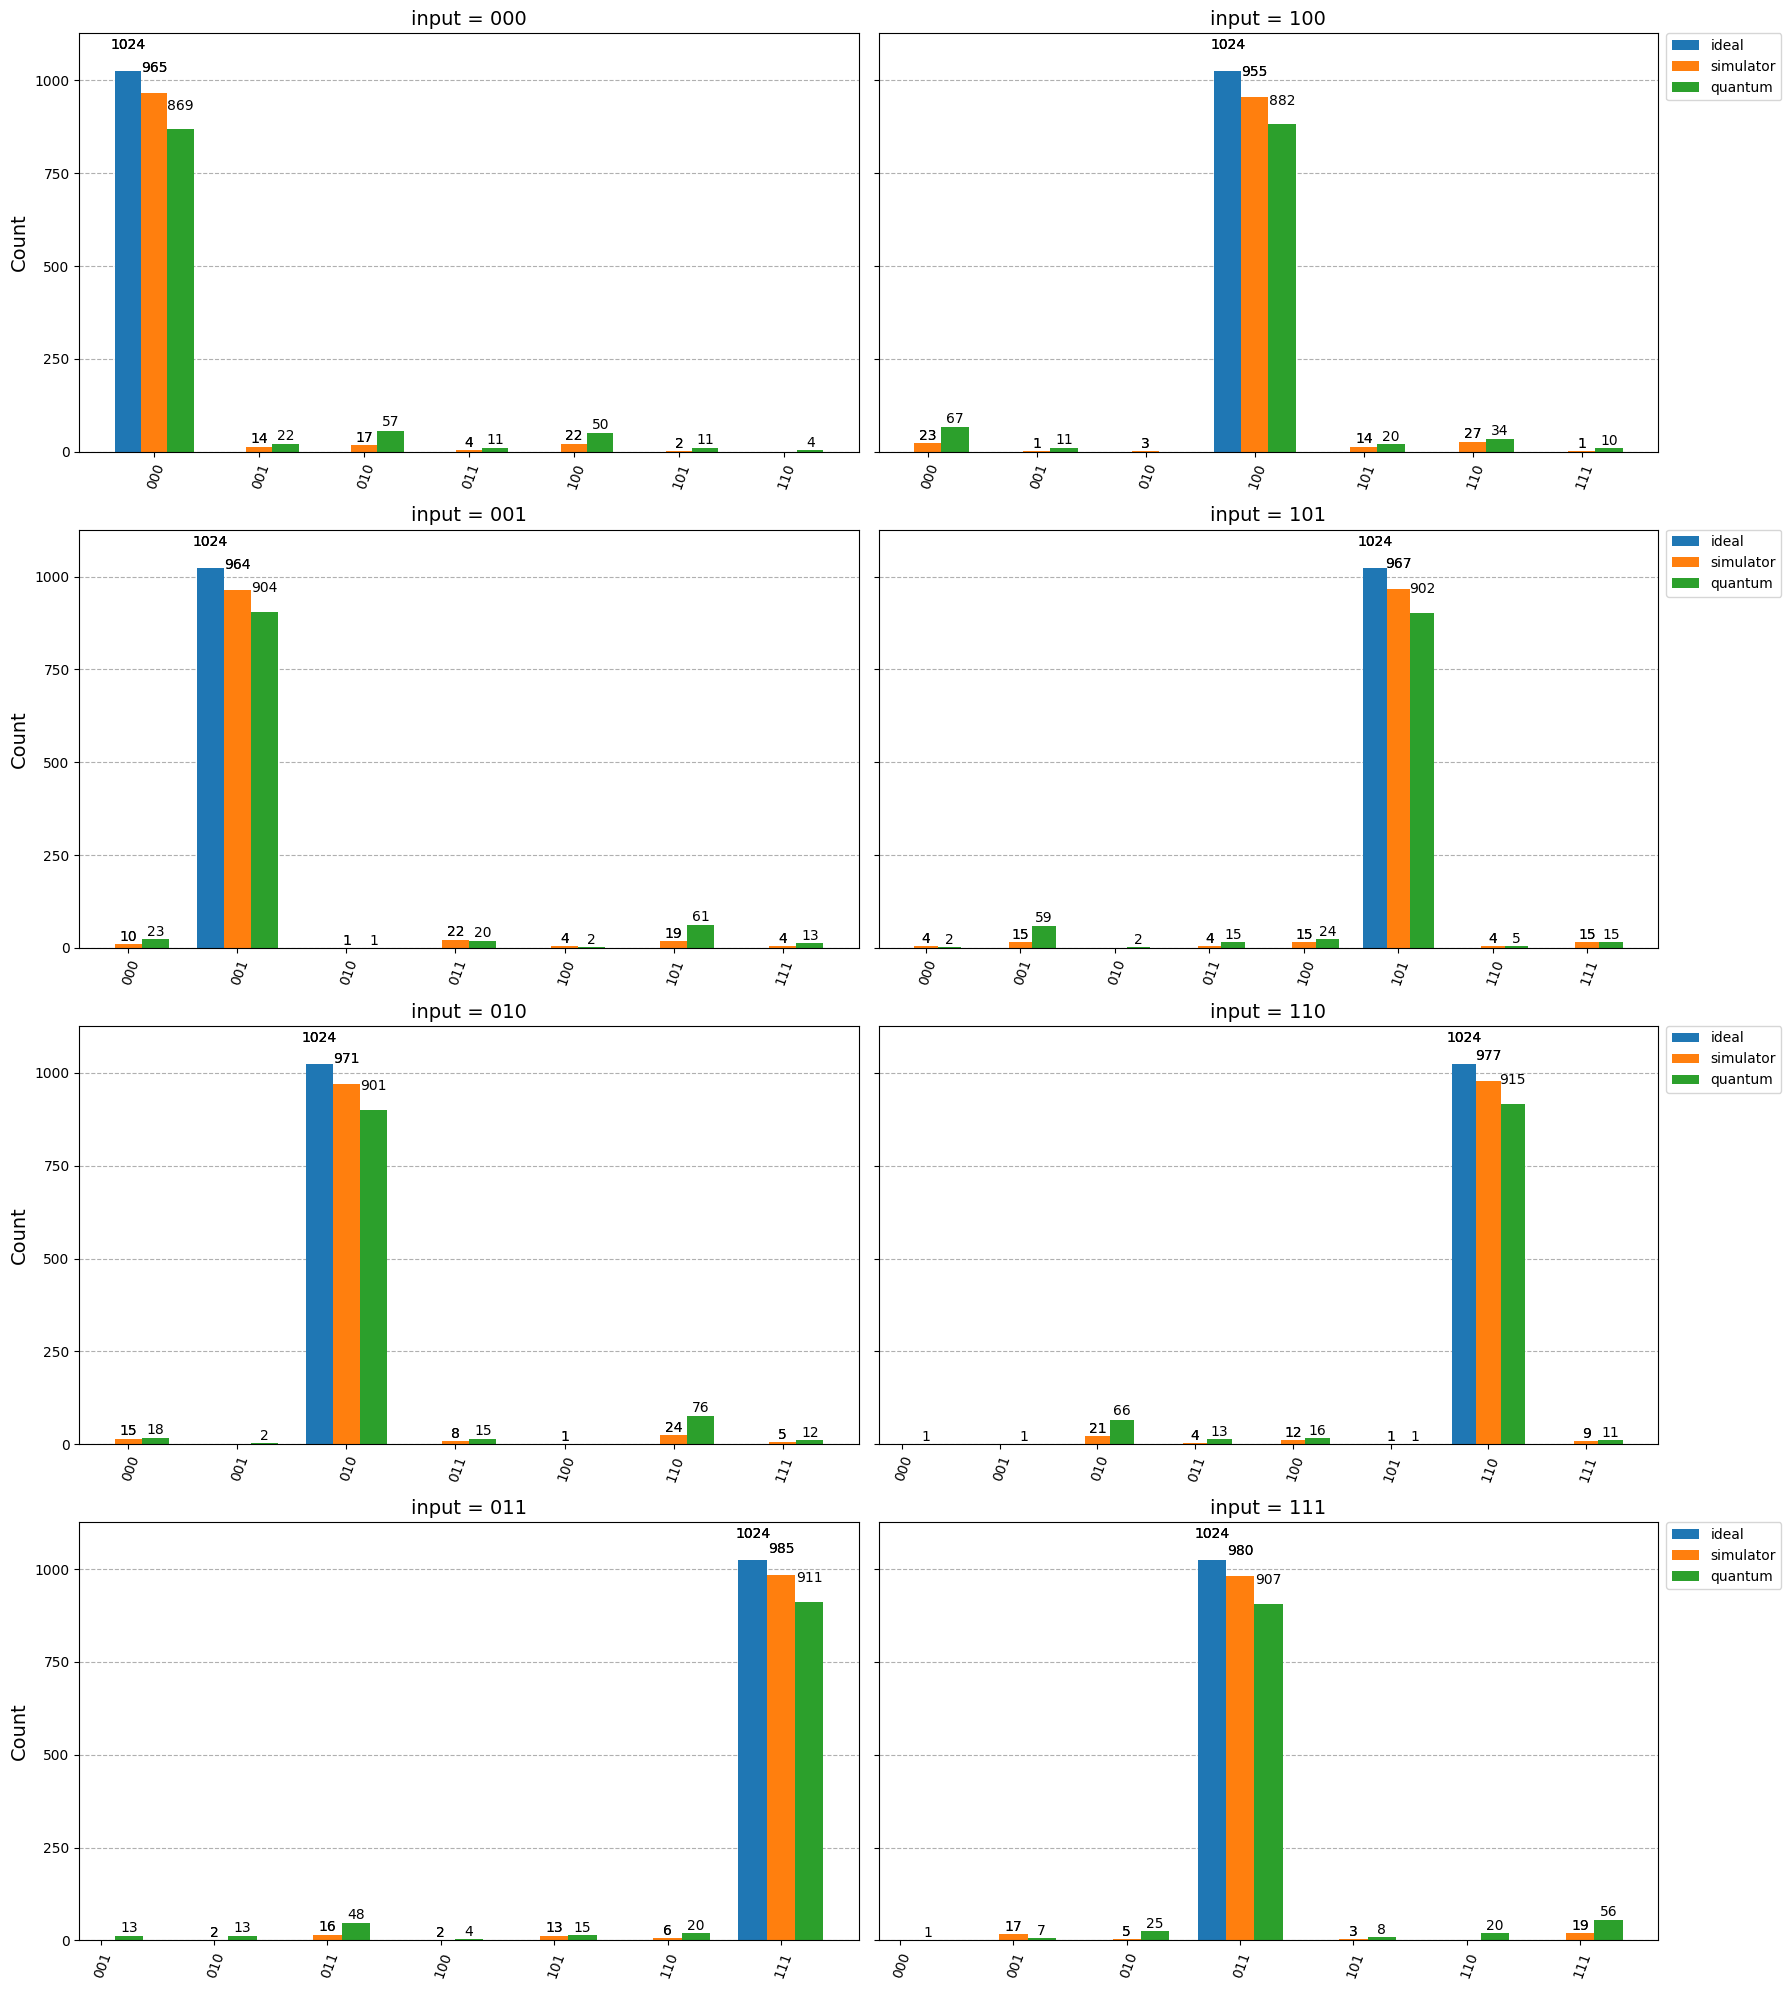

In [17]:
from qiskit.visualization import plot_histogram

fig, ax = plt.subplots(4, 2, sharey=True, figsize=(18, 20))

for i, bs in enumerate(qc_all):
    j, k = i % 4, i // 4
    plot_histogram([counts_ideal[bs], counts_sim_noisy[bs], counts_true[bs]],
                   legend=['ideal', 'simulator', 'quantum'],  ax=ax[j, k]) 
    ax[j, k].set_title(f"input = {bs}", fontsize=14)
    if k == 0:
        ax[j, k].get_legend().remove()
    else:
        ax[j, k].set_ylabel('')
    ax[j, k].grid(ls='--', axis='y')
fig.tight_layout()
plt.savefig('hist_1024.png')
plt.show()